Montar Google drive para leer y guardar los datos

Cambiar model_output_dir por directorio de salida deseado

In [ ]:
# Montar google drive si se usa colab
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/MyDrive/Colab Notebooks/LaneNavigation'

Mounted at /content/gdrive


Comprobar carpeta de imagenes

In [ ]:
#!ls '/content/gdrive/MyDrive/AutoMig/data/imgs'

Importar librerias necesarias

In [ ]:
# Librerias estandar
import os
import random
import fnmatch
import datetime
import pickle

# Procesamiento
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.8.2
keras.__version__: 2.8.0


Importar imágenes desde el drive.
Cambiar "data_dir" por la ruta donde guardes las imágenes de entrenamiento.

In [ ]:
#!ls
data_dir = '/content/gdrive/MyDrive/AutoMig/data/lane_detect_imgs'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.jpg"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # En nombre_020_123.jpg el angulo de giro está en *_123.jpg
        steering_angles.append(angle)


Comprobar alguna de las imagenes para ver si se han cargado correctamente

image_path: /content/gdrive/MyDrive/AutoMig/data/lane_detect_imgs/CSIcamera_4886_078.jpg
steering_Angle: 78


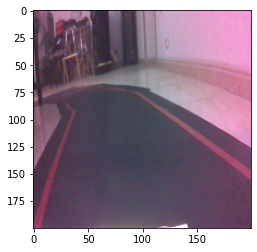

In [ ]:
image_index = 3300
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

Analisis de las distribución del angulo de giro. Las imágenes de entreno son en el circuito en sentido antihorario, asi que es normal que la mayoria del angulo sea < 90.
Con los augments se generarán mas imágenes.

(array([45.0000, 99.0000, 104.0000, 172.0000, 223.0000, 312.0000, 240.0000,
        248.0000, 266.0000, 229.0000, 331.0000, 359.0000, 596.0000,
        543.0000, 811.0000, 406.0000, 482.0000, 304.0000, 110.0000,
        87.0000, 110.0000, 43.0000, 14.0000, 10.0000, 16.0000]),
 array([28.0000, 31.5600, 35.1200, 38.6800, 42.2400, 45.8000, 49.3600,
        52.9200, 56.4800, 60.0400, 63.6000, 67.1600, 70.7200, 74.2800,
        77.8400, 81.4000, 84.9600, 88.5200, 92.0800, 95.6400, 99.2000,
        102.7600, 106.3200, 109.8800, 113.4400, 117.0000]),
 <a list of 25 Patch objects>)

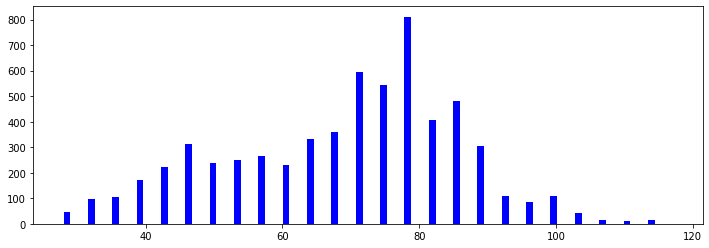

In [ ]:
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Separando datos de entreno y prueba

Training data: 4928
Validation data: 1232


Text(0.5, 1.0, 'Validation Data')

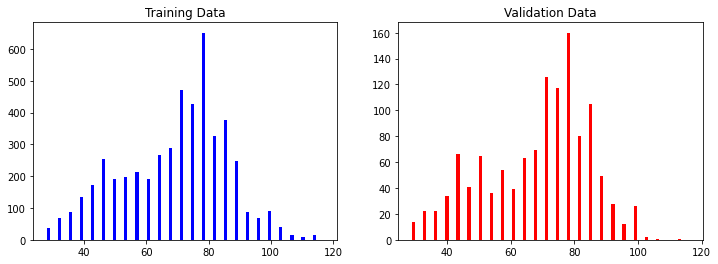

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot de las distribuciones de entreno y test para ver que sean consistentes
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

# Creando mas imágenes con augmentations

zoom

Text(0.5, 1.0, 'zoomed')

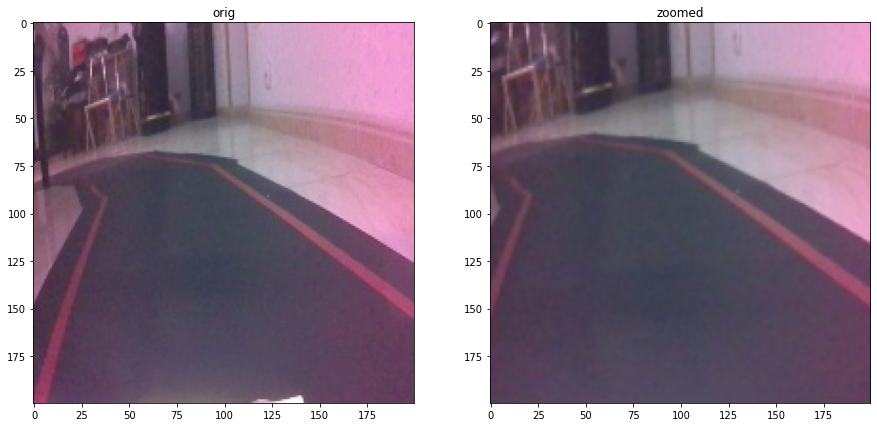

In [ ]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom de 30%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

Panning

Text(0.5, 1.0, 'panned')

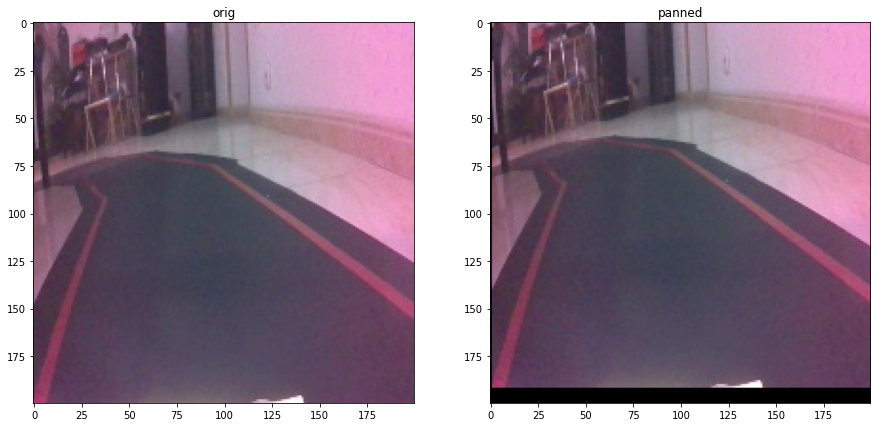

In [ ]:
def pan(image):
    # pan left / right / up / down un 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

Cambiando brillo

Text(0.5, 1.0, 'brightness adjusted')

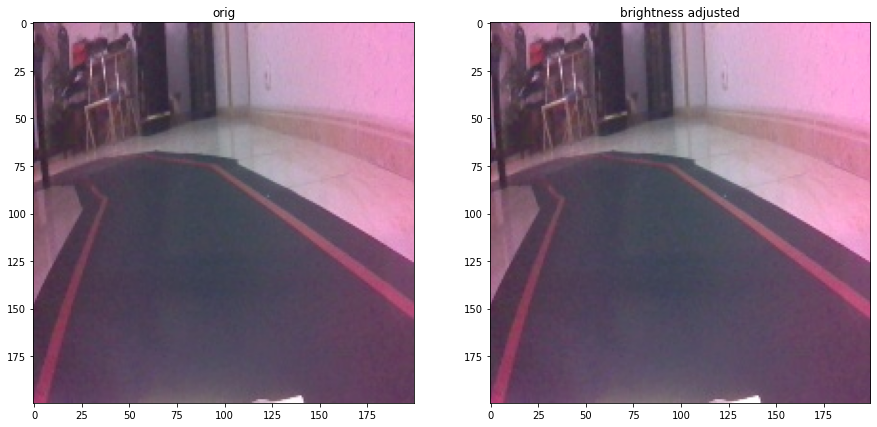

In [ ]:
def adjust_brightness(image):
    # aumentar o disminuir brillo 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Borronado

Text(0.5, 1.0, 'blurred')

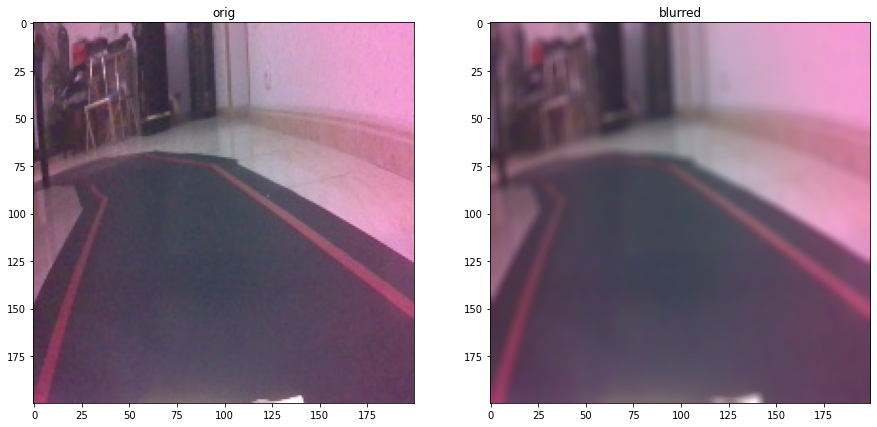

In [ ]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel mayor a 5 hace la imgen demasiado borrosa
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Girando 90 grados aleatoriamente para contemplar el circuito en el otro sentido

Text(0.5, 1.0, 'flipped, angle=102')

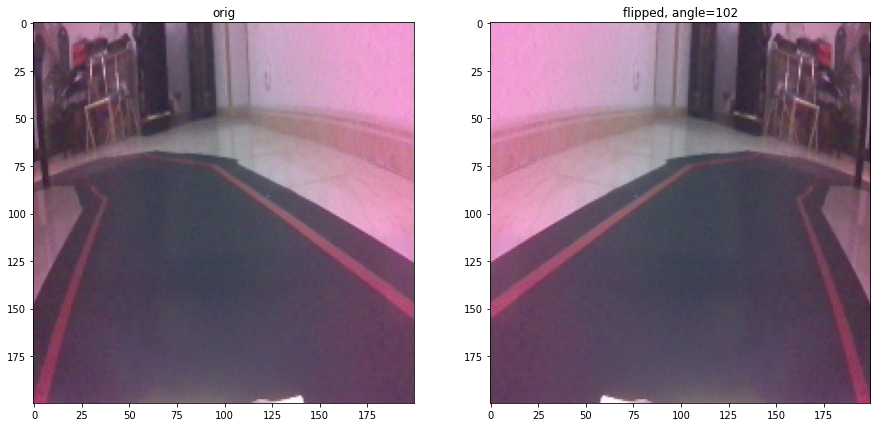

In [ ]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # flip horizontal aleatorio
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

Ahora se juntan todas y se agregan al set

Tambien se mostrarán algunas para comprobar como quedan

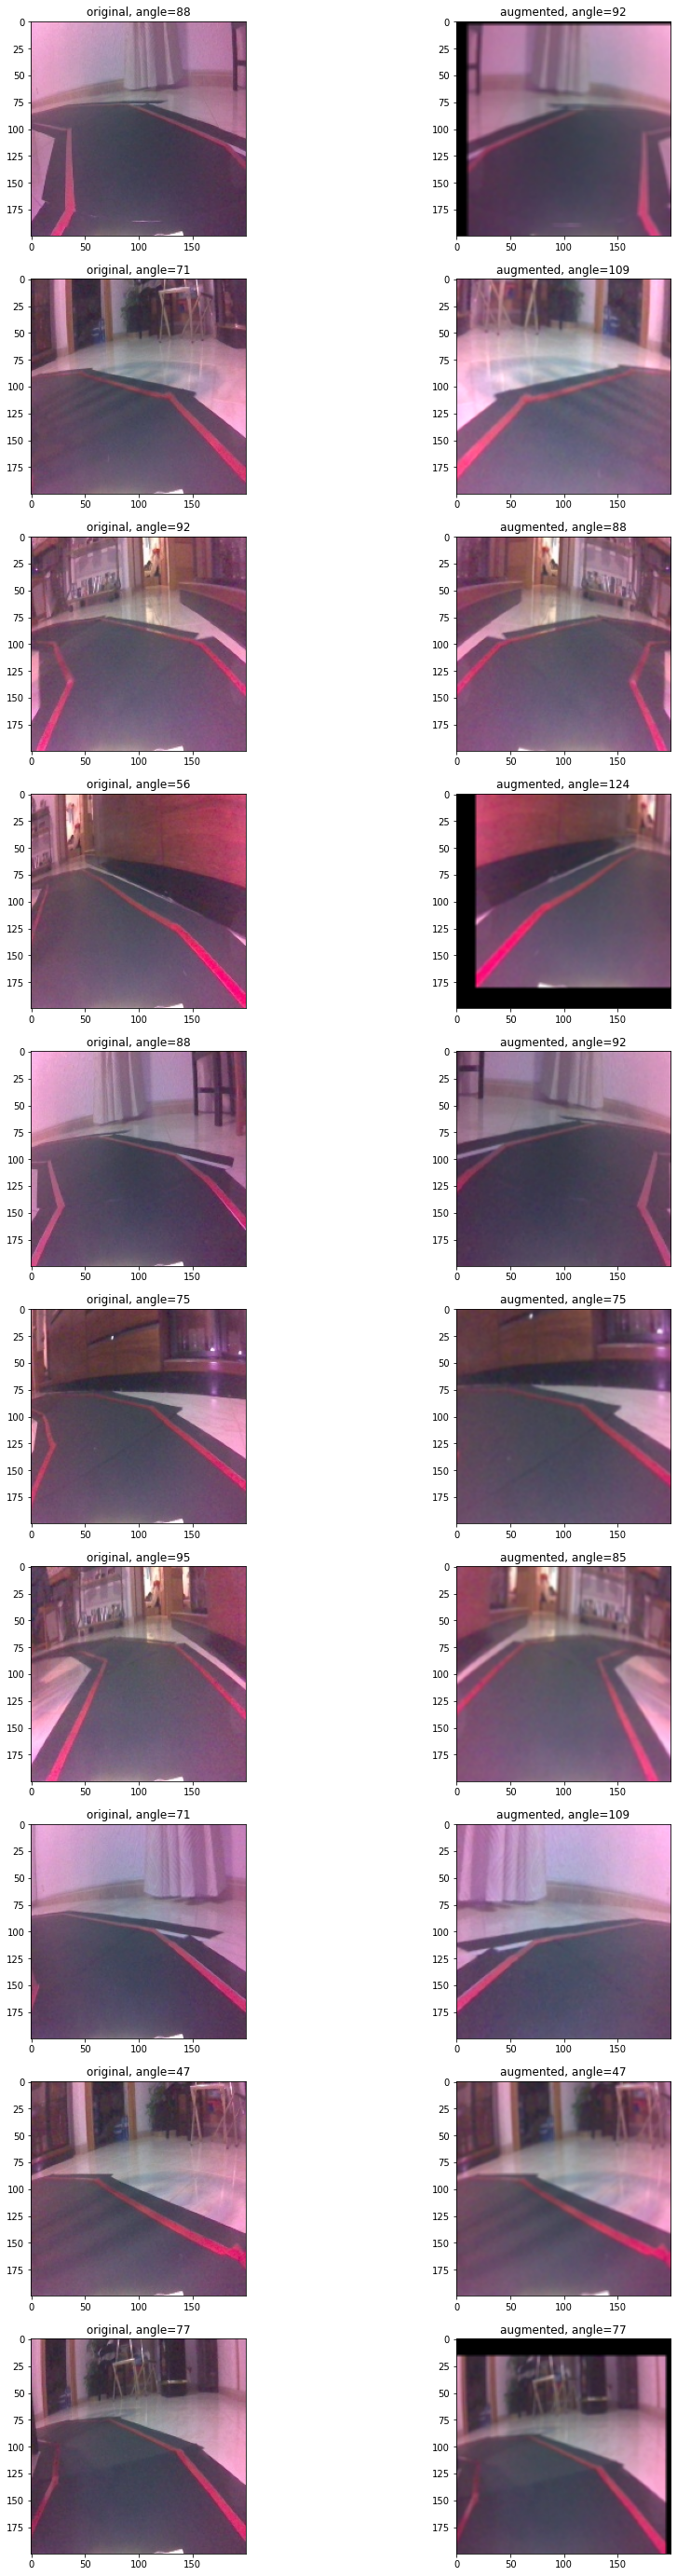

In [ ]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# Algunas imágenes de muestra
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)

Text(0.5, 1.0, 'processed')

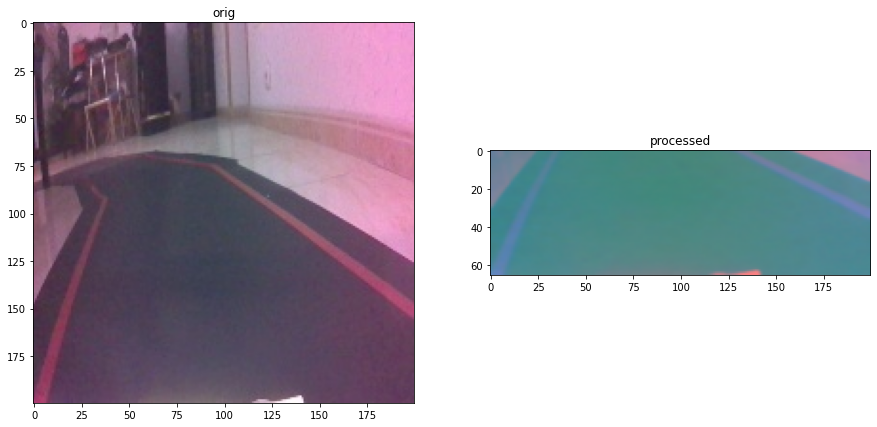

In [ ]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # quitar la mitad superior de la imagen, es irrelevante
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Pasar las imágenes al espacio de color YUV
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # tamaño de entrada al modelo 22x66
    image = image / 255 # normalización
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

La estructura del modelo es similar a la que usó Nvidia

In [ ]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit
    # no hay 1er hidden layer porque ya he normalizado los datos antes
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (angulo 45-135, 90 es recto, <90 izquierda, >90 derecha)
    model.add(Dense(1)) 
    
    # MSE = Mean Squared Error, porque es regresion, no clasificación
    optimizer = Adam(lr=1e-3) # lr = learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [ ]:
model = nvidia_model()
print(model.summary())
# 252,219 parámetros para entrenar

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout_2 (Dropout)         (None, 3, 20, 64)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


General los datos de imagen

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

Separar set para entreno y validación

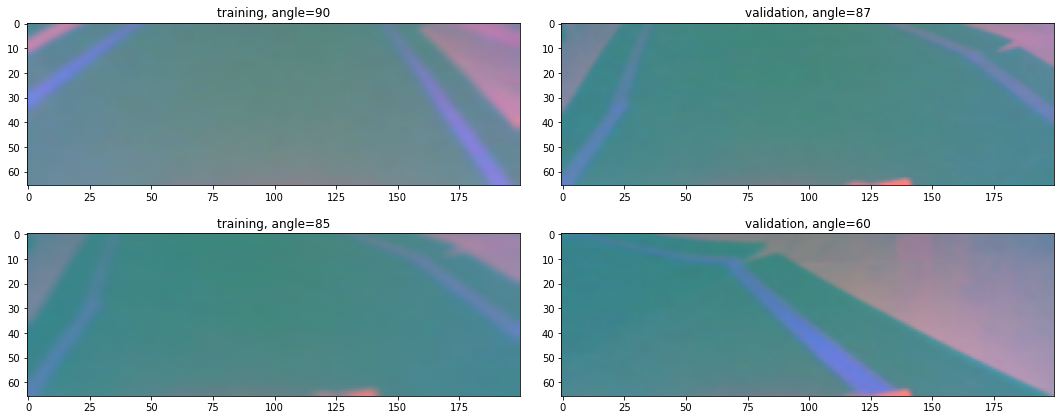

In [ ]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [ ]:
PARA AQUI ANTES DE EMPEZAR A ENTRENAR

In [ ]:
# Guardar los pesos del modelo despues de cada epoch si la perdida ha mejorado
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 694.4122
Epoch 1: val_loss improved from inf to 100.26426, saving model to /content/gdrive/MyDrive/Colab Notebooks/LaneNavigation/lane_navigation_check.h5
300/300 [==============================] - 2236s 7s/step - loss: 694.4122 - val_loss: 100.2643
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 160.2311
Epoch 2: val_loss improved from 100.26426 to 71.73660, saving model to /content/gdrive/MyDrive/Colab Notebooks/LaneNavigation/lane_navigation_check.h5
300/300 [==============================] - 525s 2s/step - loss: 160.2311 - val_loss: 71.7366
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 99.3511
Epoch 3: val_loss improved from 71.73660 to 68.12595, saving model to /content/gdrive/MyDrive/Colab Notebooks/LaneNavigation/lane_navigation_check.h5
300/300 [==============================] - 524s 2s/step - loss: 99.3511 - val_loss: 68.1259
Epoch 4/10
300/300 [=================

In [ ]:
history.history

{'loss': [694.4121704101562,
  160.23106384277344,
  99.3510971069336,
  83.26891326904297,
  74.093017578125,
  71.45027160644531,
  68.65015411376953,
  64.33120727539062,
  61.93684005737305,
  59.83578872680664],
 'val_loss': [100.2642593383789,
  71.73660278320312,
  68.12594604492188,
  60.46903610229492,
  57.81755065917969,
  46.0760498046875,
  51.61586380004883,
  40.42028045654297,
  45.86391830444336,
  36.03512954711914]}

In [ ]:
# plot training y validation losses
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

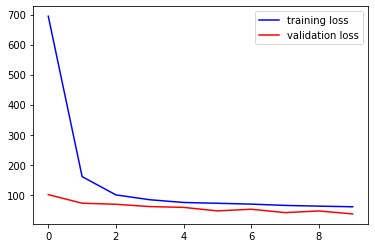

In [ ]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

Realizar algunas pruebas para comprobar el modelo

mse       = 5.2e+01
r_squared = 80.09%



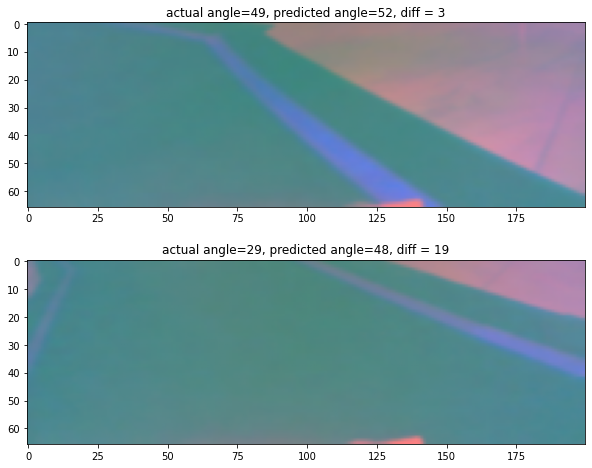

In [ ]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    